<h1 align="center"> Data ingestion and preprocessing notebook </h1>

#### Author: 
Wenwen Kong

#### Updated:
Nov 10, 2022

#### Motivation:
Explore the predictive power of local climate on annual soybean yield in the United States.


---
<a id='section_0'></a>

## Table of contents

### 1. [Understanding the datasets](#section_1)

   - #### 1.1 [GDHY soybean 1981 annual yield](#section_1.1)
   
   - #### 1.2 [Visualizing the 1981 GDHY soybean yield](#section_1.2)
   
   - #### 1.3 [NLDAS 1981 dataset](#section_1.3)
    
We employ two datasets: 
- GDHY (Global dataset of historical yields) provides annual crop yields:  [lizumi and Sakai, 2020, The global dataset of historical yields for major crops 1981-2016](https://www.nature.com/articles/s41597-020-0433-7)

- [NLDAS](https://ldas.gsfc.nasa.gov/nldas) (The North American Land Data Assimilation System) provides monthly climate variables

We focus on the United States (lon_west = 235.25, lon_east=292.75, lat_south=25.25, lat_north=52.75) Soybean annual yields from 1981 to 2016. The domain range is based on the NLDAS domain, and the temporal range is based on the GDHY range. 

GDHY includes annual yields for other crop types, including ['soybean', 'maize', 'maize_major', 'maize_second', 'rice', 'rice_major', 'rice_second', 'wheat', 'wheat_spring', 'wheat_winter']. For simplicity, the current notebook only deals with `soybean`

We do a quick check on the year 1981 data from both datasets, to make sure we understand the data, especially the missing values in GDHY, as we will use GDHY as our target. 


---

### 2. [Creating the GDHY soybean dataframe](#section_2)

   - #### 2.1 [Combining all GDHY soybean yields to one dataframe](#section_2.1)
   
   - #### 2.2 [Drop all NaN values in the GDHY_all_list dataframe](#section_2.2)

We combine all GDHY soybean yields to a single dataframe and drop all NaN values

We finally get > 50K records (i.e., total grid points across all years)

---

### 3. [Creating the NLDAS dataframe](#section_3)

   - #### 3.1 [Combine all years, all months to one dataframe](#section_3.1)
   
   - #### 3.2 [Sanity check the NLDAS_df](#section_3.2)

We combine all monthly NLDAS variables into a single dataframe, and create suffixes to denote the monthly variables. 

---

### 4. [Combine GDHY and NLDAS](#section_4)

   - #### 4.1 [Creating GDHY_NLDAS_merge](#section_4.1)
   
   - #### 4.2 [Sanity check on the results](#section_4.2)

We merge the GDHY and NLDAS dataframe together

---

### 5. [Save the data](#section_5)

Save the dataframe to a .csv file (size ~ 307MB).


---
## Future improvements 

- Define a function to visualize the soybean spatial map

- Add sliding window of soybean yield images across all years

---

## Caveats:


### Limited predictors

- Unlike some other crop types (such as corn) that are more influenced by soil type, drainage, population, row width, tillage and other physical and human factors, soybean yield is more influenced by natural environment [[Reference: Stack the odds for soybeans this spring](https://www.agweb.com/news/crops/soybeans/stack-odds-soybeans-spring)]. Still, it would be helpful to include other factors such as the genotype, soil type, and seeding experiment into consideration. In the current work, we solely focus on potential predictive power of local monthly climate on soybean yield because we did not find suitable datasets for those other predictors. This caveat may limit the predictive power of our model. 

- We only used the NLDAS for the climate data source. If time permits, one could try reproducing the work with other data sources that provide both atmospheric and land-based variables.

### One column view 

- Here, we consider a local view, meaning that we only consider impacts of local climate on local yield. It's worth including some variables that represent large-scale or remote climate conditions that can exert teleconnection impacts on the U.S. climate and thus soybean. I would like to pursue that possibility in future analysis, for now we just stick to the local view. 

### Corse timescale of crop yield data 

- The crop yields data that we use only provide annual yields, thus we don't have information related to the timing of the soybean planting and growth seasonal cycle at each location from each year. The planting timing could matter given these previous suggestions:
    - [Why Planting Soybean Early Improves Yield Potential](https://cropwatch.unl.edu/why-planting-soybean-early-improves-yield-potential), from University of Nebraska-Lincoln 
    - [Planting Soybeans Early Crucial to Optimizing Soybean Nodes and Yield](https://cropwatch.unl.edu/planting-soybeans-early-crucial-optimizing-soybean-nodes-and-yield), from University of Nebraska-Lincoln
    - [Stack the odds for soybeans this spring](https://www.agweb.com/news/crops/soybeans/stack-odds-soybeans-spring), from the AGWEB Farm Journal
    - [Soybean Planting Date, Seeding Rate, and Row Width](https://agcrops.osu.edu/newsletter/corn-newsletter/2018-11/soybean-planting-date-seeding-rate-and-row-width), from Ohio State University 
    - [Soybean planting date can have a significant impact on yield](https://crops.extension.iastate.edu/encyclopedia/soybean-planting-date-can-have-significant-impact-yield), from Iowa State University 


---

## Load libraries 

In [1]:
import os
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import numpy  as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import geopandas as gpd
import cmocean

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

from functools import reduce
import inspect

## import customized utils

In [2]:
import utils

---
## File parameters

In [3]:
# Path of the raw data files
base_dir = os.getcwd()
path_NLDAS = os.path.join(base_dir, 'downloads/NLDAS/')
path_GDHY  = os.path.join(base_dir, 'downloads/gdhy_v1.2_v1.3_20190128/')

# Crop type of focus 
crop_type  = 'soybean'

# Time range 
yr_Start   = 1981
yr_End     = 2016

# Domain range 
# This is the NLDAS domain, covering the United States
lon_west   = 235.25
lon_east   = 292.75
lat_south  = 25.25
lat_north  = 52.75

# Monthly suffixes
# We want to put monthly climate variables from each year to match the correponding year record, 
# so adding suffixes to each month's variable for notations
month_suffix = ['_Jan', '_Feb', '_Mar', '_Apr', '_May', '_Jun', \
                '_Jul', '_Aug', '_Sep', '_Oct', '_Nov', '_Dec']

# Month numbers
# This is used for reading in the monthly files form NLDAS
month_number = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

---
<a id='section_1'></a>

# 1. understanding the datasets

Back to [Table of contents](#section_0)

<a id='section_1.1'></a>

## 1.1 GDHY soybean 1981 annual yield 



In [4]:
# List the raw data files
!ls $path_GDHY

maize        maize_second rice_major   soybean      wheat_spring
maize_major  rice         rice_second  wheat        wheat_winter


In [5]:
# List the files in the crop type of interest
path_crop = path_GDHY + crop_type + '/'
!ls $path_crop

yield_1981.nc4 yield_1989.nc4 yield_1997.nc4 yield_2005.nc4 yield_2013.nc4
yield_1982.nc4 yield_1990.nc4 yield_1998.nc4 yield_2006.nc4 yield_2014.nc4
yield_1983.nc4 yield_1991.nc4 yield_1999.nc4 yield_2007.nc4 yield_2015.nc4
yield_1984.nc4 yield_1992.nc4 yield_2000.nc4 yield_2008.nc4 yield_2016.nc4
yield_1985.nc4 yield_1993.nc4 yield_2001.nc4 yield_2009.nc4
yield_1986.nc4 yield_1994.nc4 yield_2002.nc4 yield_2010.nc4
yield_1987.nc4 yield_1995.nc4 yield_2003.nc4 yield_2011.nc4
yield_1988.nc4 yield_1996.nc4 yield_2004.nc4 yield_2012.nc4


In [6]:
# ********************************* 
#   Read in yield_1981.nc4 
# ********************************* 

test_GDHY_ds     = xr.open_dataset(path_crop + 'yield_1981.nc4')
test_GDHY_df     = test_GDHY_ds.to_dataframe()

# .reset_index() helps to assign lat and lon for each entry
test_GDHY_df     = test_GDHY_df.reset_index()

# Read in bnds 0 only, and sort values by the ascending order of lat and lon
#test_NLDAS_sorted = test_NLDAS_df[test_NLDAS_df['bnds'] == 0].sort_values(by = ['lat', 'lon'])
#test_GDHY_sorted.head()

# Create a year column to store the year value 
test_GDHY_df['year'] = str(1981)
# A lazy way to rename the var column to yield, and drop the original var column
test_GDHY_df['yield'] = test_GDHY_df['var']
test_GDHY_df.drop('var', axis = 1, inplace=True)
test_GDHY_df.head()

,lat,lon,year,yield
0,-89.75,0.25,1981,NaN
1,-89.75,0.75,1981,NaN
2,-89.75,1.25,1981,NaN
3,-89.75,1.75,1981,NaN
4,-89.75,2.25,1981,NaN


In [7]:
# **************************************************************************** 
#   Select the subdomain (United States) to be consistent with NLDAS domain
# **************************************************************************** 
test_GDHY_df_sub = test_GDHY_df[(test_GDHY_df['lat'] >= lat_south) & (test_GDHY_df['lat'] <= lat_north) \
               & (test_GDHY_df['lon'] >= lon_west) & (test_GDHY_df['lon'] <= lon_east)]

# Sort by lat and lon
test_GDHY_df_sub = test_GDHY_df_sub.sort_values(by = ['lat', 'lon'])
# Reset the index column to and drop the original one
test_GDHY_df_sub.reset_index(drop=True, inplace=True)
test_GDHY_df_sub.head()

,lat,lon,year,yield
0,25.25,235.25,1981,NaN
1,25.25,235.75,1981,NaN
2,25.25,236.25,1981,NaN
3,25.25,236.75,1981,NaN
4,25.25,237.25,1981,NaN


In [8]:
test_GDHY_df_sub.describe()

,lat,lon,yield
count,6496.000000,6496.000000,1341.000000
mean,39.000000,264.000000,1.988872
std,8.082237,16.743824,0.818072
min,25.250000,235.250000,0.177305
25%,32.125000,249.625000,1.553903
50%,39.000000,264.000000,2.109541
75%,45.875000,278.375000,2.544625
max,52.750000,292.750000,5.121251


In [9]:
# How many data points are NaN in this year?
test_GDHY_df_sub.isna().sum()

lat         0
lon         0
year        0
yield    5155
dtype: int64

In [10]:
# How many datapoints are not NaN in this year?
len(test_GDHY_df_sub['yield']) - test_GDHY_df_sub.isna().sum()

lat      6496
lon      6496
year     6496
yield    1341
dtype: int64

---
<a id='section_1.2'></a>

## 1.2 Visualizing the 1981 GDHY soybean yield

Back to the [Table of contents](#section_0)

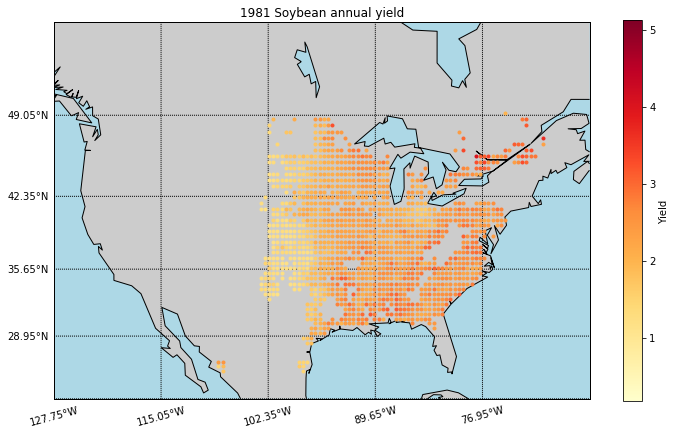

In [11]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap

import matplotlib
# How much to zoom from coordinates (in degrees)
zoom_scale = 3

# Setup the bounding box for the zoom and bounds of the map
xx   = test_GDHY_df_sub
lats = xx['lat']
lons = xx['lon']

bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

fig, ax = plt.subplots(figsize=(12,7))
plt.title("1981 Soybean annual yield")

# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='c')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='#CCCCCC',lake_color='lightblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=15)
m.drawmapboundary(fill_color='lightblue')

# format colors for annual yield range
alt_min = np.min(xx['yield'])
alt_max = np.max(xx['yield'])
#cmap = plt.get_cmap('gist_earth')
cmap = plt.get_cmap('YlOrRd')
normalize = matplotlib.colors.Normalize(vmin=alt_min, vmax=alt_max)

# plot yield with different colors using the numpy interpolation mapping tool
# the range [50,200] can be changed to create different colors and ranges
for ii in range(0,len(xx['yield'])):
    x,y = m(lons[ii],lats[ii])
    if pd.notna(xx['yield'][ii]):
        color_interp = np.interp(xx['yield'][ii],[alt_min,alt_max],[50,200])
        plt.plot(x,y,marker='o',markersize=3,color=cmap(int(color_interp)))
        #plt.plot(x, y, marker = 'o', markersize=6)
        
# format the colorbar 
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=normalize,label='Yield')

# save the figure and show it
#plt.savefig('asos_station_elevation.png', format='png', dpi=500,transparent=True)
plt.show()

## As we can see, the NaN values in the 1981 soybean dataframe either denote oceanic values or denote land regions that do not yield soybean or simply have missing values. As will be shown later in the notebook, the count of NaN values vary from year to year. 


---
<a id='section_1.3'></a>

## 1.3 NLDAS 1981 dataset 

Back to the [Table of contents](#section_0)

In [12]:
# Check datafiles within the path_NLDAS
!ls $path_NLDAS

NLDAS2_README.pdf
NLDAS_NOAH0125_M.A197901.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197902.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197903.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197904.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197905.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197906.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197907.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197908.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197909.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197910.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197911.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A197912.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198001.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198002.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198003.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198004.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198005.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198006.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198007.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198008.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198009.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198010.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198011.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A198012.020.nc.SUB.nc4
NLDAS_NOAH0125_M.A1981

In [13]:
# ********************************* 
#   Read in 198101 (Jan of 1981) 
# ********************************* 

test_NLDAS_ds     = xr.open_dataset(path_NLDAS + 'NLDAS_NOAH0125_M.A198101.020.nc.SUB.nc4')
test_NLDAS_df     = test_NLDAS_ds.to_dataframe()

# .reset_index() helps to assign lat and lon for each entry
test_NLDAS_df     = test_NLDAS_df.reset_index()

# Read in bnds 0 only, and sort values by the ascending order of lat and lon
test_NLDAS_sorted = test_NLDAS_df[test_NLDAS_df['bnds'] == 0].sort_values(by = ['lat', 'lon'])
test_NLDAS_sorted.head()

,bnds,lat,lon,time,time_bnds,SWdown,LWdown,SWnet,LWnet,Qle,...,CCond,RCS,RCT,RCQ,RCSOL,RSmin,RSMacr,LAI,GVEG,Streamflow
6380,0,25.25,235.25,1981-01-01,1981-01-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6381,0,25.25,235.75,1981-01-01,1981-01-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6382,0,25.25,236.25,1981-01-01,1981-01-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6383,0,25.25,236.75,1981-01-01,1981-01-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6384,0,25.25,237.25,1981-01-01,1981-01-01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# drop the bnds, time_bnds column
test_NLDAS_sorted.drop(['bnds', 'time_bnds'], axis=1, inplace=True)

# Replace the values in the time column with the year value 
test_NLDAS_sorted['time'] = '1981'

# Reset the index column to and drop the original one
test_NLDAS_sorted.reset_index(drop=True, inplace=True)

test_NLDAS_sorted.head()

,lat,lon,time,SWdown,LWdown,SWnet,LWnet,Qle,Qh,Qg,...,CCond,RCS,RCT,RCQ,RCSOL,RSmin,RSMacr,LAI,GVEG,Streamflow
0,25.25,235.25,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25.25,235.75,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.25,236.25,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25.25,236.75,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25.25,237.25,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Print out a list of columna names in NLDAS

In [15]:
NLDAS_df_column_names = list(test_NLDAS_sorted)
NLDAS_df_column_names

['lat',
 'lon',
 'time',
 'SWdown',
 'LWdown',
 'SWnet',
 'LWnet',
 'Qle',
 'Qh',
 'Qg',
 'Qf',
 'Snowf',
 'Rainf',
 'Evap',
 'Qs',
 'Qsb',
 'Qsm',
 'AvgSurfT',
 'Albedo',
 'SWE',
 'SnowDepth',
 'SnowFrac',
 'SoilT_0_10cm',
 'SoilT_10_40cm',
 'SoilT_40_100cm',
 'SoilT_100_200cm',
 'SoilM_0_10cm',
 'SoilM_10_40cm',
 'SoilM_40_100cm',
 'SoilM_100_200cm',
 'SoilM_0_100cm',
 'SoilM_0_200cm',
 'RootMoist',
 'SMLiq_0_10cm',
 'SMLiq_10_40cm',
 'SMLiq_40_100cm',
 'SMLiq_100_200cm',
 'SMAvail_0_100cm',
 'SMAvail_0_200cm',
 'PotEvap',
 'ECanop',
 'TVeg',
 'ESoil',
 'SubSnow',
 'CanopInt',
 'ACond',
 'CCond',
 'RCS',
 'RCT',
 'RCQ',
 'RCSOL',
 'RSmin',
 'RSMacr',
 'LAI',
 'GVEG',
 'Streamflow']

---
<a id='section_2'></a>

# 2. Creating the GDHY soybean dataframe 

## Note:

- ### Each year's dataframe contains a bunch of NaN yield values, some of those values are over ocean, some of those values are over land regions that do not produce soybean or have missing values. We want to discard the NaN points and just focus on regions with non-NaN values. 

- ### The non-NaN grid points are not consistent across all years. That is, some years possess more missing values than others. [lizumi and Sakai (2020)](https://www.nature.com/articles/s41597-020-0433-7) mentioned that the begining and ending years across the whole period (1981-2016) have relatively more missing values than the middle years. 

Back to [Table of contents](#section_0)

---
<a id='section_2.1'></a>

## 2.1 Combining all GDHY soybean yields to one dataframe:

In [16]:
years  = list(range(yr_Start, yr_End+1))
df_list= []
for year in years:
    df = xr.open_dataset(path_crop + 'yield_'+str(year)+'.nc4').to_dataframe()
    # .reset_index() helps to assign lat and lon for each entry
    df = df.reset_index()
    
    # Create a year column to store the year value 
    df['year'] = str(year)
    
    # A lazy way to rename the var column to yield, and drop the original var column
    df['yield'] = df['var']
    df.drop('var', axis = 1, inplace=True)

    # **************************************************************************** 
    #   Select the subdomain (United States) to be consistent with NLDAS domain
    # **************************************************************************** 
    df_sub = df[(df['lat'] >= lat_south) & (df['lat'] <= lat_north) \
                   & (df['lon'] >= lon_west) & (df['lon'] <= lon_east)]

    # Sort by lat and lon
    df_sub = df_sub.sort_values(by = ['lat', 'lon'])
    # Reset the index column to and drop the original one
    df_sub.reset_index(drop=True, inplace=True)

    # Pring out the number of NaN values for this year
    print(crop_type+': year '+str(year)+' has NaN values counts = '+ str(df_sub['yield'].isna().sum()))
    
    # Append the df_sub to df_list
    df_list.append(df_sub)
    
GDHY_all_list = pd.concat(df_list)

soybean: year 1981 has NaN values counts = 5155
soybean: year 1982 has NaN values counts = 4995
soybean: year 1983 has NaN values counts = 4995
soybean: year 1984 has NaN values counts = 4995
soybean: year 1985 has NaN values counts = 4995
soybean: year 1986 has NaN values counts = 4995
soybean: year 1987 has NaN values counts = 4995
soybean: year 1988 has NaN values counts = 4995
soybean: year 1989 has NaN values counts = 4995
soybean: year 1990 has NaN values counts = 4995
soybean: year 1991 has NaN values counts = 4995
soybean: year 1992 has NaN values counts = 4995
soybean: year 1993 has NaN values counts = 4995
soybean: year 1994 has NaN values counts = 4995
soybean: year 1995 has NaN values counts = 4995
soybean: year 1996 has NaN values counts = 4995
soybean: year 1997 has NaN values counts = 4995
soybean: year 1998 has NaN values counts = 4995
soybean: year 1999 has NaN values counts = 4995
soybean: year 2000 has NaN values counts = 4995
soybean: year 2001 has NaN values counts

### Clearly, the number of NaN values vary from year to year. Most years have missing value = 4995, while year 1981 and years after 2010 have more missing values. 

### Let's plot year 1981, 1991, 2001, and 2011 separately, which will give us a visual sense of the difference in the spatial coverage. 

In [17]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap

In [18]:
# OSError: Unable to open boundary dataset file. Only the 'crude' and  'low',
# resolution datasets are installed by default.
# If you are requesting an, 'intermediate', 'high' or 'full'
# resolution dataset, you may need to download and install those
# files separately with
# `conda install -c conda-forge basemap-data-hires`.

In [19]:
# conda install -c conda-forge basemap-data-hires

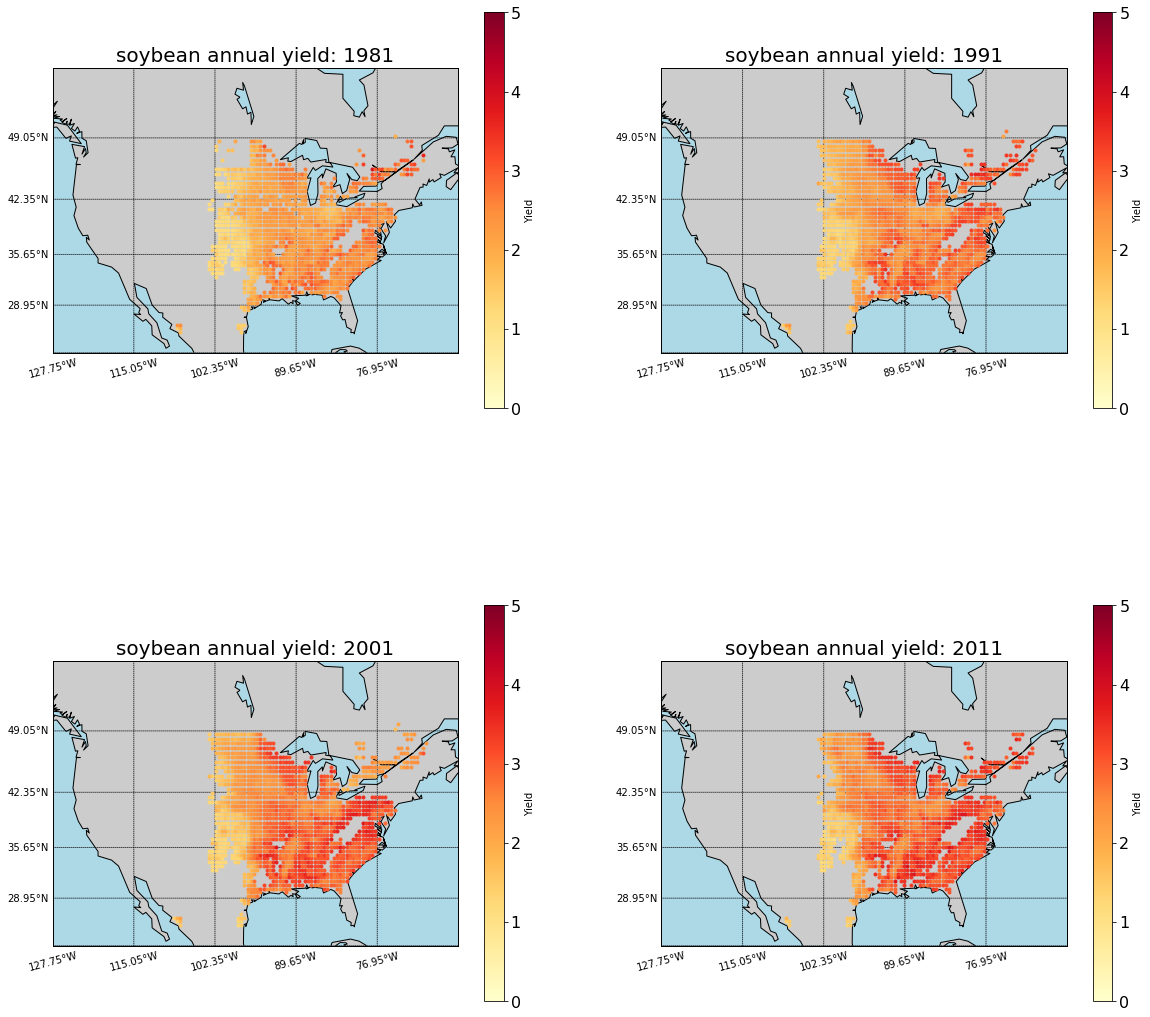

In [20]:
# ************************************************************
# Panel of four years 
# Can we eye ball discernible difference in the NaN space?
# ************************************************************
import matplotlib
fig, axes   = plt.subplots(2, 2, figsize = (20, 20))
panel_year  = ['1981', '1991', '2001', '2011']

# **********************************
# Loop through the panel years
# **********************************
for year in panel_year:
    
    xxxx = GDHY_all_list[GDHY_all_list['year'] == year] 
    
    if panel_year.index(year) == 0:
        row    = 0
        column = 0
    elif panel_year.index(year) == 1:
        row    = 0
        column = 1
    elif panel_year.index(year) == 2:
        row    = 1
        column = 0
    else:
        row    = 1
        column = 1
                
    # How much to zoom from coordinates (in degrees)
    zoom_scale = 3

    # Setup the bounding box for the zoom and bounds of the map
    lats = xxxx['lat']
    lons = xxxx['lon']

    bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
            np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

    #fig, ax = plt.subplots(figsize=(12,7))
    #plt.title("1981 Soybean annual yield")

    # Define the projection, scale, the corners of the map, and the resolution.
    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='c', ax=axes[row, column])

    # Draw coastlines and fill continents and water with color
    m.drawcoastlines()
    m.fillcontinents(color='#CCCCCC',lake_color='lightblue')

    # draw parallels, meridians, and color boundaries
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=15)
    m.drawmapboundary(fill_color='lightblue')
    
    # format colors for annual yield range
    #alt_min = np.min(xxxx['yield'])
    #alt_max = np.max(xxxx['yield'])
    alt_min  = 0
    alt_max  = 5
    
    #cmap = plt.get_cmap('gist_earth')
    cmap = plt.get_cmap('YlOrRd')
    normalize = matplotlib.colors.Normalize(vmin=alt_min, vmax=alt_max)

    # plot yield with different colors using the numpy interpolation mapping tool
    # the range [50,200] can be changed to create different colors and ranges
    for ii in range(0,len(xxxx['yield'])):
        x,y = m(lons[ii],lats[ii])
        if pd.notna(xxxx['yield'][ii]):
            color_interp = np.interp(xxxx['yield'][ii],[alt_min,alt_max],[50,200])
            axes[row, column].plot(x,y,marker='o',markersize=3,color=cmap(int(color_interp)))

    # format the colorbar 
    cax, _ = matplotlib.colorbar.make_axes(axes[row, column], shrink=0.8, extend="max")
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,norm=normalize,label='Yield')
    cbar.ax.tick_params(labelsize=16) 
    cbar.ax.set_label('Annual yield')

    axes[row, column].set_title(crop_type+' annual yield: '+year,fontsize=20)

#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)


---
<a id='section_2.2'></a>

## 2.2 Drop all NaN values in the GDHY_all_list dataframe

Back to the [Table of contents](#section_0)

In [21]:
GDHY_all_list_NaN_dropped = GDHY_all_list.dropna()
GDHY_all_list_NaN_dropped.head()

,lat,lon,year,yield
34,25.25,252.25,1981,1.222455
53,25.25,261.75,1981,0.730697
149,25.75,251.75,1981,0.720959
150,25.75,252.25,1981,1.450878
168,25.75,261.25,1981,1.049755


In [22]:
GDHY_all_list_NaN_dropped.info

<bound method DataFrame.info of         lat     lon  year     yield
34    25.25  252.25  1981  1.222455
53    25.25  261.75  1981  0.730697
149   25.75  251.75  1981  0.720959
150   25.75  252.25  1981  1.450878
168   25.75  261.25  1981  1.049755
...     ...     ...   ...       ...
5511  48.75  264.75  2016  3.735792
5556  48.75  287.25  2016  2.936604
5557  48.75  287.75  2016  2.824051
5558  48.75  288.25  2016  2.862302
5559  48.75  288.75  2016  3.414211

[53384 rows x 4 columns]>

### Sanity check that the NaN_dropped dataframe does not have NaN anymore

In [23]:
GDHY_all_list_NaN_dropped.isna().sum()

lat      0
lon      0
year     0
yield    0
dtype: int64

### Sanity check that the total count of GDHY_all_list_NaN_dropped dataframe = total count of raw data points - total count of NaN values in the raw dataframe

In [24]:
# The number of NaNs from the original GDHY_all_list dataframe
GDHY_all_list.isna().sum()

lat           0
lon           0
year          0
yield    180472
dtype: int64

In [25]:
# Double check whether the number of non-NaN entries is consistent with the length of GDHY_all_list_NaN_dropped
len(GDHY_all_list['yield']) - GDHY_all_list['yield'].isna().sum()

53384

---
<a id='section_3'></a>

# 3. Creating the NLDAS dataframe

Back to [Table of contents](#section_0)

---
<a id='section_3.1'></a>

## 3.1 Combine all years, all months to one dataframe

### Note:

We create NLDAS dataframe from 1979 to 2016 (instead of 1981 to 2016) and save as a separate .csv file. 

The reason is that when we do EDA and feature selection, we would like to test whether climate variables from previous years could be good predictors. Therefore, having a saved .csv containing the NLDAS from 1979 to 2016 will be handy.

Note that this won't affect what we do in [section 4](#section_4), which aims to combine GDHY_all_list_NaN_dropped and the NLDAS_df. In section 4, we will still be able to create a combined dataframe containing 1981-2016 soybean yield with matched climate variables at same locations and time range. 

### Use the `fetch_NLDAS` function from `utils` to read all NLDAS to one dataframe

In [26]:
print(inspect.getdoc(utils.fetch_NLDAS))

Combine all NLDAS data to one dataframe.

Parameters
----------
path: string
    path where the raw netcdf NLDAS datasets live
    in my case, the path is '/Users/wenwen/Downloads/CropYield/DATA/NLDAS/'
    
yr_Start: int
    the beginning year of interest 

yr_End: int
    the ending year of interest 

month_number: list of strings 
    used to read in the months of interest from raw NLDAS .nc4 files
    for example: month_number = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    could also read in fewer months if that's desired 
    
month_suffix: list of strings
    suffix to be added for each month's variable for notations 
    for example: 
    month_suffix = ['_Jan', '_Feb', '_Mar', '_Apr', '_May', '_Jun', '_Jul', '_Aug', '_Sep', '_Oct', '_Nov', '_Dec']

Returns
----------
Dataframe 


In [27]:
NLDAS_df = utils.fetch_NLDAS(path_NLDAS, yr_Start, yr_End, month_number, month_suffix)

NLDAS year 1981 is processed...
NLDAS year 1982 is processed...
NLDAS year 1983 is processed...
NLDAS year 1984 is processed...
NLDAS year 1985 is processed...
NLDAS year 1986 is processed...
NLDAS year 1987 is processed...
NLDAS year 1988 is processed...
NLDAS year 1989 is processed...
NLDAS year 1990 is processed...
NLDAS year 1991 is processed...
NLDAS year 1992 is processed...
NLDAS year 1993 is processed...
NLDAS year 1994 is processed...
NLDAS year 1995 is processed...
NLDAS year 1996 is processed...
NLDAS year 1997 is processed...
NLDAS year 1998 is processed...
NLDAS year 1999 is processed...
NLDAS year 2000 is processed...
NLDAS year 2001 is processed...
NLDAS year 2002 is processed...
NLDAS year 2003 is processed...
NLDAS year 2004 is processed...
NLDAS year 2005 is processed...
NLDAS year 2006 is processed...
NLDAS year 2007 is processed...
NLDAS year 2008 is processed...
NLDAS year 2009 is processed...
NLDAS year 2010 is processed...
NLDAS year 2011 is processed...
NLDAS ye

---
<a id='section_3.2'></a>

## 3.2 Sanity check the NLDAS_df 

Back to the [Table of contents](#section_0)

In [28]:
NLDAS_df.head()

,lat,lon,year,SWdown_Jan,LWdown_Jan,SWnet_Jan,LWnet_Jan,Qle_Jan,Qh_Jan,Qg_Jan,...,CCond_Dec,RCS_Dec,RCT_Dec,RCQ_Dec,RCSOL_Dec,RSmin_Dec,RSMacr_Dec,LAI_Dec,GVEG_Dec,Streamflow_Dec
0,25.25,235.25,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25.25,235.75,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.25,236.25,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25.25,236.75,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25.25,237.25,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
NLDAS_df.info

<bound method DataFrame.info of         lat     lon  year  SWdown_Jan  LWdown_Jan  SWnet_Jan  LWnet_Jan  \
0     25.25  235.25  1981         NaN         NaN        NaN        NaN   
1     25.25  235.75  1981         NaN         NaN        NaN        NaN   
2     25.25  236.25  1981         NaN         NaN        NaN        NaN   
3     25.25  236.75  1981         NaN         NaN        NaN        NaN   
4     25.25  237.25  1981         NaN         NaN        NaN        NaN   
...     ...     ...   ...         ...         ...        ...        ...   
6491  52.75  290.75  2016   47.541519  214.142181  18.522751 -18.312634   
6492  52.75  291.25  2016   48.519188  212.281860  19.067738 -18.771843   
6493  52.75  291.75  2016   48.829102  210.970840  18.859039 -19.098591   
6494  52.75  292.25  2016   49.048012  210.485611  18.979172 -20.014515   
6495  52.75  292.75  2016   48.793816  209.473572  19.300339 -20.834042   

       Qle_Jan    Qh_Jan    Qg_Jan  ...  CCond_Dec   RCS_Dec  RCT_D

## NaN values in NLDAS_df:

- ### Like GDHY, NLDAS is a land-based dataset, so values over ocean are NaNs.
- ### Besides oceanic values, there are also missing values over land. But overall, NLDAS covers larger spatial domain than GDHY. 

## Variables in NLDAS_df:
- ### As shown above, for each year, we keep monthly variables across the whole year. Taking 'SWdown' (downward solar radiation) for example, we have 'SWdown_Jan', 'SWdown_Feb', ..., 'SWdown_Dec' for each year. This allows us to take the seasonality of climate variables into consideration.  

---
<a id='section_4'></a>

# 4. Combine GDHY and NLDAS

## Note:

- ### Our goal is to use NLDAS data to predict crop yield

- ### As we saw earlier, we dropped NaN values from the crop yield, and the total counts of NaN values from crop yield vary from year to year. We don't need to have the same sample size (e.g., grid points) for each year, as long as we make sure there is one to one correspondance between the GDHY and NLDAS dataset.

- ### Therefore, we will merge the GDHY_all_list_NaN_dropped dataframe with the NLDAS dataframe, based on the ['lat', 'lon', 'year'] columns. By doing so, only grid points having non-NaN GDHY values would be merged from NLDAS. 

- ### The assumption of our approach is that we view all the non-NaN grid points and their connection with the local climate is interchangable.  

Back to [Table of contents](#section_0)

---
## Double-check the information of  GDHY_all_list_NaN_dropped dataframe

- ### It has 53384 records, so we expect the final merged dataframe has 53384 records as well.

In [30]:
GDHY_all_list_NaN_dropped.info

<bound method DataFrame.info of         lat     lon  year     yield
34    25.25  252.25  1981  1.222455
53    25.25  261.75  1981  0.730697
149   25.75  251.75  1981  0.720959
150   25.75  252.25  1981  1.450878
168   25.75  261.25  1981  1.049755
...     ...     ...   ...       ...
5511  48.75  264.75  2016  3.735792
5556  48.75  287.25  2016  2.936604
5557  48.75  287.75  2016  2.824051
5558  48.75  288.25  2016  2.862302
5559  48.75  288.75  2016  3.414211

[53384 rows x 4 columns]>

---
<a id='section_4.1'></a>

## 4.1 Creating GDHY_NLDAS_merge

Back to the [Table of contents](#section_0)

In [31]:
GDHY_NLDAS_merge = GDHY_all_list_NaN_dropped.merge(NLDAS_df, on = ['lat', 'lon', 'year'], how = 'left')
GDHY_NLDAS_merge.head()

,lat,lon,year,yield,SWdown_Jan,LWdown_Jan,SWnet_Jan,LWnet_Jan,Qle_Jan,Qh_Jan,...,CCond_Dec,RCS_Dec,RCT_Dec,RCQ_Dec,RCSOL_Dec,RSmin_Dec,RSMacr_Dec,LAI_Dec,GVEG_Dec,Streamflow_Dec
0,25.25,252.25,1981,1.222455,159.920837,346.994659,130.236633,-58.938141,49.757866,24.595564,...,0.003209,0.296489,0.945595,0.761561,0.507833,70.00,0.160229,2.580852,0.408217,NaN
1,25.25,261.75,1981,0.730697,123.256218,340.839294,90.953438,-47.860847,30.156218,15.754601,...,0.002931,0.291933,0.928706,0.841513,0.488691,70.00,0.039061,2.136915,0.169220,NaN
2,25.75,251.75,1981,0.720959,158.171448,344.052582,129.672607,-61.418865,50.223949,21.417778,...,0.003299,0.296670,0.945852,0.769458,0.514206,70.00,0.045652,2.528653,0.379176,NaN
3,25.75,252.25,1981,1.450878,157.280960,329.239502,131.438965,-59.363853,51.495888,23.997215,...,0.003447,0.259533,0.905129,0.762109,0.399981,70.00,0.079119,4.030976,0.552567,NaN
4,25.75,261.25,1981,1.049755,121.048691,334.779541,86.365326,-48.992542,26.840885,13.713440,...,0.002115,0.280767,0.898908,0.856690,0.518298,138.75,0.038237,2.069846,0.207283,NaN


In [32]:
GDHY_NLDAS_merge.info

<bound method DataFrame.info of          lat     lon  year     yield  SWdown_Jan  LWdown_Jan   SWnet_Jan  \
0      25.25  252.25  1981  1.222455  159.920837  346.994659  130.236633   
1      25.25  261.75  1981  0.730697  123.256218  340.839294   90.953438   
2      25.75  251.75  1981  0.720959  158.171448  344.052582  129.672607   
3      25.75  252.25  1981  1.450878  157.280960  329.239502  131.438965   
4      25.75  261.25  1981  1.049755  121.048691  334.779541   86.365326   
...      ...     ...   ...       ...         ...         ...         ...   
53379  48.75  264.75  2016  3.735792   58.571480  226.915985   29.846769   
53380  48.75  287.25  2016  2.936604   68.403191  238.822403   10.893313   
53381  48.75  287.75  2016  2.824051         NaN         NaN         NaN   
53382  48.75  288.25  2016  2.862302   70.961464  240.115387   19.141396   
53383  48.75  288.75  2016  3.414211   64.889366  234.438614    9.980240   

       LWnet_Jan    Qle_Jan     Qh_Jan  ...     CCond_D

## --> The merged dataframe has 53384 records, looks good. 

---
<a id='section_4.2'></a>

## 4.2 Sanity check on the results. 

### Let's plot yield, July rainfall and July temperature in year 1981, just to make sure they aline with each other. 

Back to the [Table of contents](#section_0)

In [33]:
GDHY_NLDAS_merge['Rainf_Jul'].describe()

count    53099.000000
mean        99.149071
std         55.909729
min          0.000000
25%         60.463951
50%         90.422409
75%        128.019226
max       1376.996582
Name: Rainf_Jul, dtype: float64

In [34]:
GDHY_NLDAS_merge['AvgSurfT_Jul'].describe()

count    53099.000000
mean       298.282959
std          3.539976
min        286.111267
25%        295.600891
50%        298.459808
75%        301.088257
max        310.209106
Name: AvgSurfT_Jul, dtype: float64

In [35]:
merge_1981 = GDHY_NLDAS_merge[GDHY_NLDAS_merge['year'] == '1981']

In [36]:
merge_1981.head()

,lat,lon,year,yield,SWdown_Jan,LWdown_Jan,SWnet_Jan,LWnet_Jan,Qle_Jan,Qh_Jan,...,CCond_Dec,RCS_Dec,RCT_Dec,RCQ_Dec,RCSOL_Dec,RSmin_Dec,RSMacr_Dec,LAI_Dec,GVEG_Dec,Streamflow_Dec
0,25.25,252.25,1981,1.222455,159.920837,346.994659,130.236633,-58.938141,49.757866,24.595564,...,0.003209,0.296489,0.945595,0.761561,0.507833,70.00,0.160229,2.580852,0.408217,NaN
1,25.25,261.75,1981,0.730697,123.256218,340.839294,90.953438,-47.860847,30.156218,15.754601,...,0.002931,0.291933,0.928706,0.841513,0.488691,70.00,0.039061,2.136915,0.169220,NaN
2,25.75,251.75,1981,0.720959,158.171448,344.052582,129.672607,-61.418865,50.223949,21.417778,...,0.003299,0.296670,0.945852,0.769458,0.514206,70.00,0.045652,2.528653,0.379176,NaN
3,25.75,252.25,1981,1.450878,157.280960,329.239502,131.438965,-59.363853,51.495888,23.997215,...,0.003447,0.259533,0.905129,0.762109,0.399981,70.00,0.079119,4.030976,0.552567,NaN
4,25.75,261.25,1981,1.049755,121.048691,334.779541,86.365326,-48.992542,26.840885,13.713440,...,0.002115,0.280767,0.898908,0.856690,0.518298,138.75,0.038237,2.069846,0.207283,NaN


### Plot of 1981 annual yield

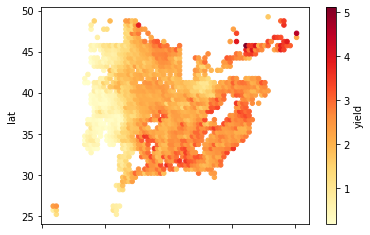

In [37]:
merge_1981.plot(x = 'lon', y = 'lat', kind = 'scatter', c = 'yield', colormap = 'YlOrRd')

### Plot of 1981 July Rainfall 

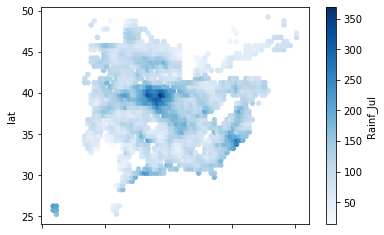

In [38]:
merge_1981.plot(x = 'lon', y = 'lat', kind = 'scatter', c = 'Rainf_Jul', colormap = 'Blues')

### Plot of 1981 July surface temperature 

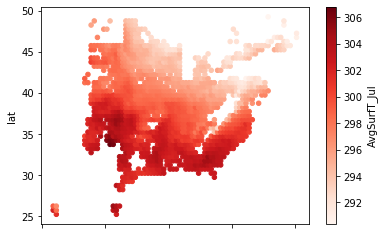

In [39]:
merge_1981.plot(x = 'lon', y = 'lat', kind = 'scatter', c = 'AvgSurfT_Jul', colormap = 'Reds')

---
<a id='section_5'></a>

# 5. Save the data

Back to the [Table of contents](#section_0)

In [40]:
data_dir = os.path.join(base_dir, 'data/')
GDHY_NLDAS_merge.to_csv(data_dir+'./GDHY_'+crop_type+'_NLDAS_'+str(yr_Start)+'-'+str(yr_End)+'.csv')